# Steel plate faults multiclass classification

In [1]:
# load libraries
from e2eml.classification import classification_blueprints as cb
from e2eml.full_processing.postprocessing import save_to_production, load_for_production
from e2eml.test.classification_blueprints_test import steel_fault_multiclass_data
import pandas as pd
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
import re

[nltk_data] Downloading package punkt to /home/thomas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/thomas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Feature engineering
Load & preprocess steel faults dataset.

In [2]:
# load steel faults data
test_df, test_target, val_df, val_df_target, test_categorical_cols = steel_fault_multiclass_data()

# Using e2eml - Run and save a pipeline
In this notebook we configure a custom pipeline. Due to the object-oriented approach we can easily set this up.
Under the hood the main and mostly used blueprint pipeline looks like this:

def pipeline(self):
        logging.info('Start blueprint.')
        try:
            if df.empty:
                skip_train = False
            else:
                self.dataframe = df
                skip_train = True
        except AttributeError:
            skip_train = False
        self.train_test_split(how=self.train_split_type)
        self.datetime_converter(datetime_handling='all', force_conversion=False)
        if preprocessing_type == 'nlp':
            self.pos_tagging_pca()
        self.rare_feature_processor(threshold=0.03, mask_as='miscellaneous')
        self.cardinality_remover(threshold=100)
        self.onehot_pca()
        self.category_encoding(algorithm='target')
        self.delete_high_null_cols(threshold=0.5)
        self.fill_nulls(how='static')
        self.data_binning(nb_bins=10)
        #self.skewness_removal()
        self.outlier_care(method='isolation', how='append')
        self.remove_collinearity(threshold=0.8)
        self.clustering_as_a_feature(algorithm='dbscan', eps=0.3, n_jobs=-1, min_samples=10)
        for nb_cluster in range(2, 10):
            self.clustering_as_a_feature(algorithm='kmeans', nb_clusters=nb_cluster)
        if self.low_memory_mode:
            self.reduce_memory_footprint()
        self.automated_feature_selection(metric='logloss')
        self.sort_columns_alphabetically()
        if skip_train:
            pass
        else:
            self.lgbm_train(tune_mode=self.tune_mode)
        self.lgbm_predict(feat_importance=True)
        self.classification_eval('lgbm')
        self.prediction_mode = True
        logging.info('Finished blueprint.')

From here we can make custom choices by:
- skipping steps
- changing parameters
- or even extend

We follow these steps:
- instantiate class
- define and run pipeline
- save and load pipeline
- predict on new data

In [3]:
# Instantiate class
steel_faults_ml = cb.ClassificationBluePrint(datasource=test_df,
                                       target_variable=test_target,
                                       categorical_columns=test_categorical_cols,
                                       preferred_training_mode='auto',
                                       tune_mode='accurate')

Preferred training mode auto has been chosen. e2eml will automatically detect, if LGBM and Xgboost canuse GPU acceleration and optimize the workflow accordingly.


In [4]:
"""
Define custom pipeline...
- Please note, that there are logical and technical dependencies. Not everything is possible.
"""
def custom_pipeline(df, steel_faults_ml):
    try:
        if df.empty:
            steel_faults_ml.prediction_mode = False
        else:
            steel_faults_ml.dataframe = df
            steel_faults_ml.prediction_mode = True
    except AttributeError:
        steel_faults_ml.prediction_mode = False
    steel_faults_ml.train_test_split(how=steel_faults_ml.train_split_type)
    try:
        print(steel_faults_ml.df_dict["Y_train"])
    except AttributeError:
        #does not exist in prediction mode
        pass
    steel_faults_ml.datetime_converter(datetime_handling='all', force_conversion=False)
    steel_faults_ml.pos_tagging_pca()
    # we removed rare feature processing
    steel_faults_ml.cardinality_remover(threshold=200) #raised
    steel_faults_ml.onehot_pca()
    steel_faults_ml.category_encoding(algorithm='target')
    """
    Custom pipelines allow you to inject your own data manipulation or to access the data in between.
    The train and test data is always stored in the df_dict attribute.
    """
    try:
        print(steel_faults_ml.df_dict["X_train"].isna().sum())
    except AttributeError:
        #changed location in prediction mode
        print(steel_faults_ml.dataframe.isna().sum())
    steel_faults_ml.delete_high_null_cols(threshold=0.4) # lowered to 40%
    steel_faults_ml.fill_nulls(how='iterative_imputation') # we changed to iterative filling instead of imputation with 0
    steel_faults_ml.data_binning(nb_bins=5) # we change the bins
    steel_faults_ml.outlier_care(method='isolation', how='append')
    steel_faults_ml.remove_collinearity(threshold=0.8)
    steel_faults_ml.clustering_as_a_feature(algorithm='dbscan', eps=0.3, n_jobs=-1, min_samples=10)
    for nb_cluster in range(2, 20):
        steel_faults_ml.clustering_as_a_feature(algorithm='GLMM', nb_clusters=nb_cluster) #changed from kmeans
    steel_faults_ml.automated_feature_selection(metric='logloss') # needs to be xgboost compatible
    steel_faults_ml.sort_columns_alphabetically()
    if steel_faults_ml.prediction_mode:
        pass
    else:
        steel_faults_ml.lgbm_train(tune_mode=steel_faults_ml.tune_mode)
    steel_faults_ml.lgbm_predict(feat_importance=True)
    steel_faults_ml.classification_eval('lgbm')
    steel_faults_ml.prediction_mode = True # mandatory


Started Execute test train split at 14:35:07.
Started Execute label encoding at 14:35:07.
Started Execute label encoding at 14:35:07.
364     2.0
914     0.0
72      4.0
647     2.0
908     0.0
       ... 
918     0.0
1593    3.0
350     2.0
734     2.0
1366    3.0
Name: target, Length: 1200, dtype: float64
Started Apply datetime transformation at 14:35:07.
Started Start Spacy, POS tagging + PCA at 14:35:07.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 364 to 1366
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1200 non-null   int64  
 1   X_Maximum              1184 non-null   float64
 2   Y_Minimum              1200 non-null   int64  
 3   Y_Maximum              1200 non-null   int64  
 4   Pixels_Areas           1200 non-null   int64  
 5   X_Perimeter            1200 non-null   int64  
 6   Y_Perimeter            1200 non-null   int64  
 7   Sum_of

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


X_Minimum                 0
X_Maximum                16
Y_Minimum                 0
Y_Maximum                 0
Pixels_Areas              0
X_Perimeter               0
Y_Perimeter               0
Sum_of_Luminosity         0
Minimum_of_Luminosity     0
Maximum_of_Luminosity     0
Length_of_Conveyer        0
TypeOfSteel_A300          0
TypeOfSteel_A400          0
Steel_Plate_Thickness    21
Edges_Index               0
Empty_Index              17
Square_Index              0
Outside_X_Index           0
Edges_X_Index             0
Edges_Y_Index             0
Outside_Global_Index      0
LogOfAreas                0
Log_X_Index               0
Log_Y_Index               0
Orientation_Index         0
Luminosity_Index          0
SigmoidOfAreas            0
dtype: int64
Started  Delete columns with high share of NULLs at 14:35:07.
Started Fill nulls at 14:35:08.
Started Execute numerical binning at 14:35:08.
Started Handle outliers at 14:35:08.
Started Remove collinearity at 14:35:09.
Started Exec

Found `num_iterations` in params. Will use it instead of argument
[I 2021-07-18 14:35:10,916] A new study created in memory with name: no-name-917b897c-5c4d-4ecb-b1bf-0c0db498459f
Found `num_boost_round` in params. Will use it instead of argument


[LightGBM] [Info] Using GPU Device: GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2 dense feature groups (0.00 MB) transferred to GPU in 0.000150 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LGBM uses GPU.


[I 2021-07-18 14:35:11,811] Trial 0 finished with value: 1.9468828547230703 and parameters: {'num_boost_round': 11124, 'lambda_l1': 10.764254295908625, 'lambda_l2': 580436.9917093338, 'num_leaves': 80, 'feature_fraction': 0.8793035487141176, 'bagging_freq': 7, 'min_child_samples': 48, 'min_gain_to_split': 0.6178188813506457, 'learning_rate': 6.690357112063883e-07}. Best is trial 0 with value: 1.9468828547230703.
Found `num_boost_round` in params. Will use it instead of argument
[I 2021-07-18 14:35:12,661] Trial 1 finished with value: 1.94688285472307 and parameters: {'num_boost_round': 24051, 'lambda_l1': 2362.9124928075203, 'lambda_l2': 1.9058375261170994, 'num_leaves': 153, 'feature_fraction': 0.7760127973439286, 'bagging_freq': 7, 'min_child_samples': 60, 'min_gain_to_split': 0.4886232187637949, 'learning_rate': 0.00028168353841160774}. Best is trial 1 with value: 1.94688285472307.
Found `num_boost_round` in params. Will use it instead of argument
[I 2021-07-18 14:35:13,598] Trial 2

[1]	train's multi_logloss: 1.67183	valid's multi_logloss: 1.62638
Training until validation scores don't improve for 10 rounds
[2]	train's multi_logloss: 1.66106	valid's multi_logloss: 1.61629
[3]	train's multi_logloss: 1.65208	valid's multi_logloss: 1.60752
[4]	train's multi_logloss: 1.64141	valid's multi_logloss: 1.59684
[5]	train's multi_logloss: 1.63064	valid's multi_logloss: 1.58583
[6]	train's multi_logloss: 1.6206	valid's multi_logloss: 1.57602
[7]	train's multi_logloss: 1.61015	valid's multi_logloss: 1.5657
[8]	train's multi_logloss: 1.60053	valid's multi_logloss: 1.55646
[9]	train's multi_logloss: 1.5902	valid's multi_logloss: 1.54593
[10]	train's multi_logloss: 1.5797	valid's multi_logloss: 1.53542
[11]	train's multi_logloss: 1.5702	valid's multi_logloss: 1.52622
[12]	train's multi_logloss: 1.56053	valid's multi_logloss: 1.51683
[13]	train's multi_logloss: 1.5515	valid's multi_logloss: 1.50805
[14]	train's multi_logloss: 1.54227	valid's multi_logloss: 1.49908
[15]	train's mul

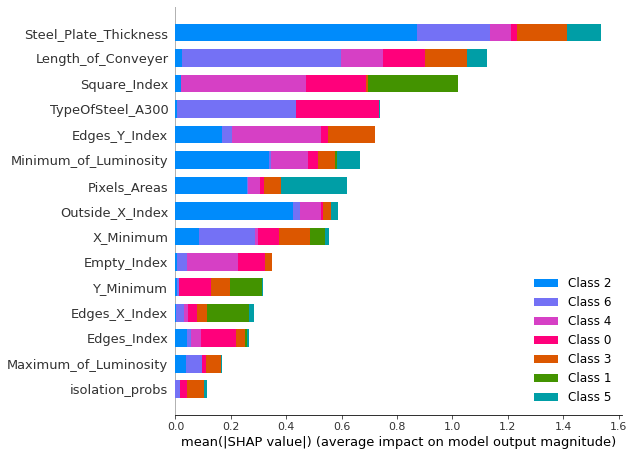

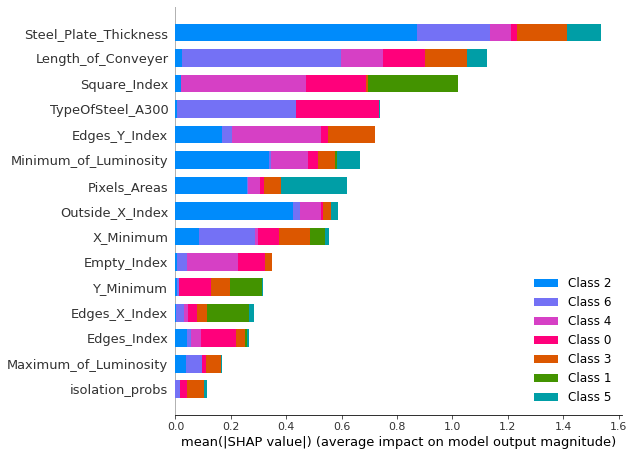

364     2.0
914     0.0
72      4.0
647     2.0
908     0.0
       ... 
918     0.0
1593    3.0
350     2.0
734     2.0
1366    3.0
Name: target, Length: 1200, dtype: float64
57      4.0
1031    0.0
237     6.0
54      4.0
1396    3.0
       ... 
497     2.0
633     2.0
977     0.0
1100    0.0
1044    0.0
Name: target, Length: 300, dtype: float64
The Matthew correlation is 0.6987084126954558
The macro F1 score is 0.6700611607328989
The micro F1 score is 0.7666666666666667
The weighted F1 score is 0.7541665713953739
              precision    recall  f1-score   support

         0.0       0.80      0.62      0.70        69
         1.0       0.00      0.00      0.00         8
         2.0       1.00      0.86      0.92        70
         3.0       0.63      0.87      0.73        99
         4.0       0.50      0.32      0.39        19
         5.0       1.00      1.00      1.00         7
         6.0       0.90      1.00      0.95        28

    accuracy                           0.77  

/home/thomas/anaconda3/envs/rapids-0.17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/thomas/anaconda3/envs/rapids-0.17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/thomas/anaconda3/envs/rapids-0.17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [5]:
# Run custom blueprint
custom_pipeline(None, steel_faults_ml)

In [6]:
# Save pipeline
try:
    save_to_production(steel_faults_ml, file_name='steel_faults_instance')
except AttributeError:
    print("""Unfortunately this does not work when e2eml has to label encode the target labels automatically.
    For saving a pipeline please provide encoded target labels. As of now this is just a fallback solution.
    This might be solved in future releases.""")

Unfortunately this does not work when e2eml has to label encode the target labels automatically.
    For saving a pipeline please provide encoded target labels. As of now this is just a fallback solution.
    This might be solved in future releases.


# Predict on new data
In the beginning we kept a holdout dataset. We use this to simulate prediction on completely new data.

In [7]:
# load stored pipeline...we skip this accordingly
# steel_faults_ml_loaded = load_for_production(file_name='steel_faults_instance')

In [8]:
# label encode targets
val_df_target = steel_faults_ml.label_encoder_decoder(val_df_target)

# predict on new data
custom_pipeline(val_df, steel_faults_ml)

# access predicted labels
val_y_hat = steel_faults_ml.predicted_classes['lgbm']

Started Execute label encoding at 14:36:24.
Started Execute test train split at 14:36:24.
Started Apply datetime transformation at 14:36:24.
Started Start Spacy, POS tagging + PCA at 14:36:24.
Started Remove cardinality at 14:36:24.
Started Onehot + PCA categorical features at 14:36:24.
Started Execute categorical encoding at 14:36:24.
X_Minimum                0
X_Maximum                4
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    5
Edges_Index              0
Empty_Index              7
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_In

In [9]:
# Assess prediction quality on holdout data
print(classification_report(val_df_target, val_y_hat))
try:
    matthews = matthews_corrcoef(val_df_target, val_y_hat)
except Exception:
    print("Matthew failed.")
    matthews = 0
print(matthews)

              precision    recall  f1-score   support

         0.0       0.68      0.51      0.58        92
         1.0       0.00      0.00      0.00        15
         2.0       0.90      0.87      0.88        82
         3.0       0.60      0.83      0.70       163
         4.0       0.62      0.35      0.45        37
         5.0       0.90      1.00      0.95        18
         6.0       0.93      0.76      0.84        34

    accuracy                           0.70       441
   macro avg       0.66      0.62      0.63       441
weighted avg       0.69      0.70      0.68       441

0.6075296773515224


/home/thomas/anaconda3/envs/rapids-0.17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/thomas/anaconda3/envs/rapids-0.17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/thomas/anaconda3/envs/rapids-0.17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

